<a href="https://colab.research.google.com/github/ysl208/pytorch_tutorial/blob/master/notebooks/01_pytorch_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Basics

## Init, helpers, utils, ...

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

from IPython.core.debugger import set_trace

%matplotlib inline

In [7]:
from ppt.utils import attr

ModuleNotFoundError: ignored

# Tensors
tensors - the atoms of machine learning

## Tensors in numpy and pytorch

In [0]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import multi_dot as mdot

In [0]:
import torch

In [10]:
# numpy
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
# torch
torch.eye(3)

In [0]:
# numpy
X = np.random.random((5, 3))
X

In [0]:
# pytorch
Y = torch.rand((5, 3))
Y

In [0]:
X.shape

In [0]:
Y.shape

In [0]:
# numpy
X.T @ X

In [0]:
# torch
Y.t() @ Y

In [0]:
# numpy
inv(X.T @ X)

In [0]:
# torch
torch.inverse(Y.t() @ Y)

## More on PyTorch Tensors

Operations are also available as methods.

In [0]:
A = torch.eye(3)
A.add(1)

In [0]:
A

Any operation that mutates a tensor in-place is post-fixed with an _. For example: x.copy_(y), x.t_(), will change x.

In [0]:
A.add_(1)
A

## Indexing and broadcasting
It works as expected:

In [0]:
A[0, 0]

In [0]:
A[0]

In [0]:
A[0:2]

In [0]:
A[:, 1:3]

## Converting

In [0]:
A = torch.eye(3)
A

In [0]:
# torch --> numpy
A.numpy()

In [0]:
# numpy --> torch
torch.from_numpy(np.eye(3))

# Autograd
Prior to `v0.4` PyTorch used the class `Variable` to record gradients. You had to wrap `Tensor`s in `Variable`s.
`Variable`s behaved like `Tensors`.

With `v0.4` `Tensor` can record gradients directly if you tell it do do so, e.g. `torch.ones(3, requires_grad=True)`.
There is no need for `Variable` anymore.

Ref:
- https://pytorch.org/docs/stable/autograd.html
- https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

In [0]:
from torch import autograd  # you rarely use it directly

In [0]:
w = torch.ones(1)
w.requires_grad

In [0]:
z = torch.ones(1) * 2
z.requires_grad

In [0]:
total = w + z
total

In [0]:
# What is going to happen here?
total.backward()

In [0]:
w = torch.ones(1, requires_grad=True)
w.requires_grad

In [0]:
total = w + z
total.requires_grad

In [0]:
total.backward()

In [0]:
w.grad

In [0]:
with torch.no_grad():
    total = w + z

total.requires_grad

# But what about the GPU?
How do I use the GPU?

If you have a GPU make sure that the right pytorch is installed

```
conda install pytorch torchvision cuda91 -c pytorch
```
Check https://pytorch.org/ for details.

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

If you have a GPU you should get something like: 
`device(type='cuda', index=0)`

You can move data to the GPU by doing `.to(device)`.

In [13]:
data = torch.eye(3)
data.to(device)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

Note: before `v0.4` one had to use `.cuda()` and `.cpu()` to move stuff to and from the GPU.
This littered the code with many:
```python
if CUDA:
    model = model.cuda()
```

# LinReg with PyTorch, Gradient Descent, and GPU

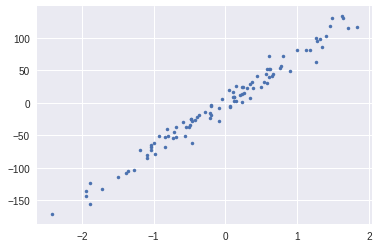

In [14]:
from sklearn.datasets import make_regression

n_features = 1
n_samples = 100

X, y = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    noise=10,
)

fix, ax = plt.subplots()
ax.plot(X, y, ".")

In [0]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.reshape((n_samples, n_features))).float()

In [0]:
from torch import nn
from torch import optim


class LinReg(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.beta = nn.Linear(input_dim, 1)
        
    def forward(self, X):
        return self.beta(X)

In [0]:
# Move everything to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LinReg(n_features).to(device)  # <-- here
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X, y = X.to(device), y.to(device)  # <-- here

In [0]:
# Train step
model.train() # start train mode
optimizer.zero_grad() # null's the gradient so that it doesn't accumulate

y_ = model(X)
loss = criterion(y_, y) # forward pass

loss.backward()
optimizer.step() # updates params of the model

# should split the data into train vs eval

# Eval
model.eval() # start eval mode
with torch.no_grad():
    y_ = model(X)    

# Vis
fig, ax = plt.subplots()
ax.plot(X.cpu().numpy(), y_.cpu().numpy(), ".", label="pred")
ax.plot(X.cpu().numpy(), y.cpu().numpy(), ".", label="data")
ax.set_title(f"MSE: {loss.item():0.1f}")
ax.legend();

# Debugging

**Q: "No debugger for your code. What do you think?"**

**A: "I would NOT be able to code!"**

- Who does "print-line-debugging"?
- Who likes debugging in tensorflow?
- What is the intersection of those two groups?


## IPDB cheatsheet
IPython Debugger

Taken from http://frid.github.io/blog/2014/06/05/python-ipdb-cheatsheet/

- h(help): Print help

- n(ext): Continue execution until the next line in the current function is reached or it returns.
- s(tep): Execute the current line, stop at the first possible occasion (either in a function that is called or in the current function).
- r(eturn): Continue execution until the current function returns.

- r(eturn): Continue execution until the current function returns.
- a(rgs): Print the argument list of the current function.

In [0]:
from IPython.core.debugger import set_trace

In [0]:
def my_function(x):
    answer = 42
    set_trace()
    answer += x
    return answer

my_function(12)

## Example: debuging a NN

In [0]:
X = torch.rand((5, 3))
X

In [0]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(3, 1)
    
    def forward(self, X):
        # set_trace()
        x = self.lin(X)
        return X

    
model = MyModule()
y_ = model(X)

assert y_.shape == (5, 1), y_.shape

# Recap - what we learned so far
- Tensor like numpy
- No need to calculate derivatives - automatic differentiation!
- Use `nn.Module` to create your own networks
- `set_trace` is your friend!